In [6]:
import pandas as pd
import fbprophet
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Pre-processing

During the Project 4 of the Master of Data Science, we got a year of data from flights in U.S. After a phase a exploration/cleanup, I prepared a dataset to try ARIMA. Now we will use this dataset to test FBProphet.

In [7]:
df = pd.read_csv("F:\Nicolas\PycharmProjects\machine_learning\datasets\arima_dataset.csv")
df_test = pd.read_csv("F:\Nicolas\PycharmProjects\machine_learning\datasets\arima_test_dataset.csv")

df.head()

,FL_DATE,CRS_DEP_TIME,DEP_DELAY
0,2016-01-06,1100.0,-3.0
1,2016-01-07,1100.0,-4.0
2,2016-01-08,1100.0,-5.0
3,2016-01-09,1100.0,2.0
4,2016-01-10,1100.0,100.0


The train dataset have a aggregations of flights from all aiports grouped by day and hour. This dataset contain all the year 2016. The dataset for test has the 6 first month of 2017. As datas, are not exactly as needed for FBProphet, let's prepare them properly. CRS_DEP_TIME is an aggregation of hour/minute (for example 1135 is 11h35). As we don't have data every 5 of 10 min, let's use a timestep of an hour.

In [8]:
def prepare_dataframe(X):
    X["CRS_DEP_TIME"] //= 100
    X = X.groupby(["FL_DATE", "CRS_DEP_TIME"]).agg({
        "DEP_DELAY" : "mean"
    }).reset_index()
    X['TDate'] = pd.to_datetime(X.FL_DATE)
    X['TDate'] +=  pd.to_timedelta(X["CRS_DEP_TIME"] , unit='h')
    X.drop(["FL_DATE", "CRS_DEP_TIME"], axis=1, inplace=True)
    X.columns = ["y", "ds"]
    return X

In [9]:
df = prepare_dataframe(df)
df_test = prepare_dataframe(df_test)

In [10]:
df.head()

,y,ds
0,6.312500,2016-01-01 00:00:00
1,-4.666667,2016-01-01 01:00:00
2,2.166667,2016-01-01 02:00:00
3,12.750000,2016-01-01 03:00:00
4,4.500000,2016-01-01 04:00:00


Now we have the column ds (for input) which is a timestamp of every hour. y is the average delay (a negative delay means that the plane took off earlier than expected).

# Setup model

We have a year of data so we cannot have the yearly seasonality but we can have the daily one.

In [11]:
model = fbprophet.Prophet(daily_seasonality=True)

In [12]:
model.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Let's predict some data (1 day to start)

In [13]:
depth = 24  # correspond to 1 day

In [9]:
future_data = model.make_future_dataframe(periods=depth, freq = 'h')

In [10]:
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8617,2017-01-01 19:00:00,21.807000,5.508640,38.330164
8618,2017-01-01 20:00:00,21.637452,4.542519,37.172411
8619,2017-01-01 21:00:00,20.061694,5.346692,36.112019
8620,2017-01-01 22:00:00,17.710395,0.776781,35.076141
8621,2017-01-01 23:00:00,15.795865,-0.158977,33.059921


We can also understand what impact lateness by looking at components of the model

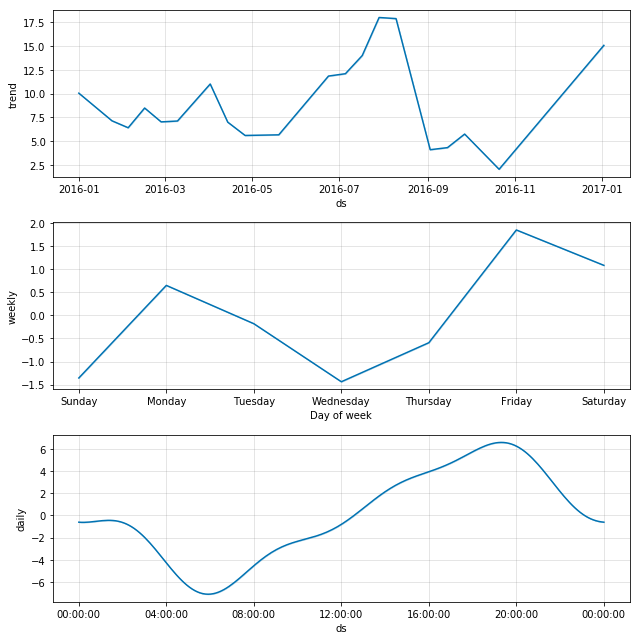

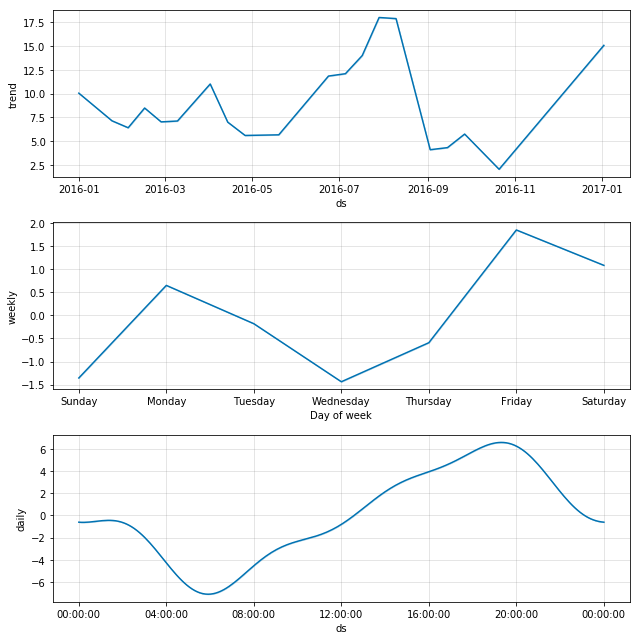

In [11]:
model.plot_components(forecast_data)

During the day, from 7AM to 8PM, the lateness increase. This is due to the accumulation of small delay. After 8PM, there is less demand so they succeed to cover lateness during the night.

For the week, we have a peak on Monday for profesionnal travellers. On Friday, there is vacation and come back from missions for the week end. During the week it's more quiet.

If we look at months now, there is a peak in summer and close to Christmas/New year. The rest of the time, the load is close to be the same.

# Prediction

We saw previously that we can predict time but also a range. Let's now evaluate the prediction on different timeframe.

### 1 Day

In [12]:
future_data = model.make_future_dataframe(periods=depth, freq = 'h')
forecast_data = model.predict(future_data)

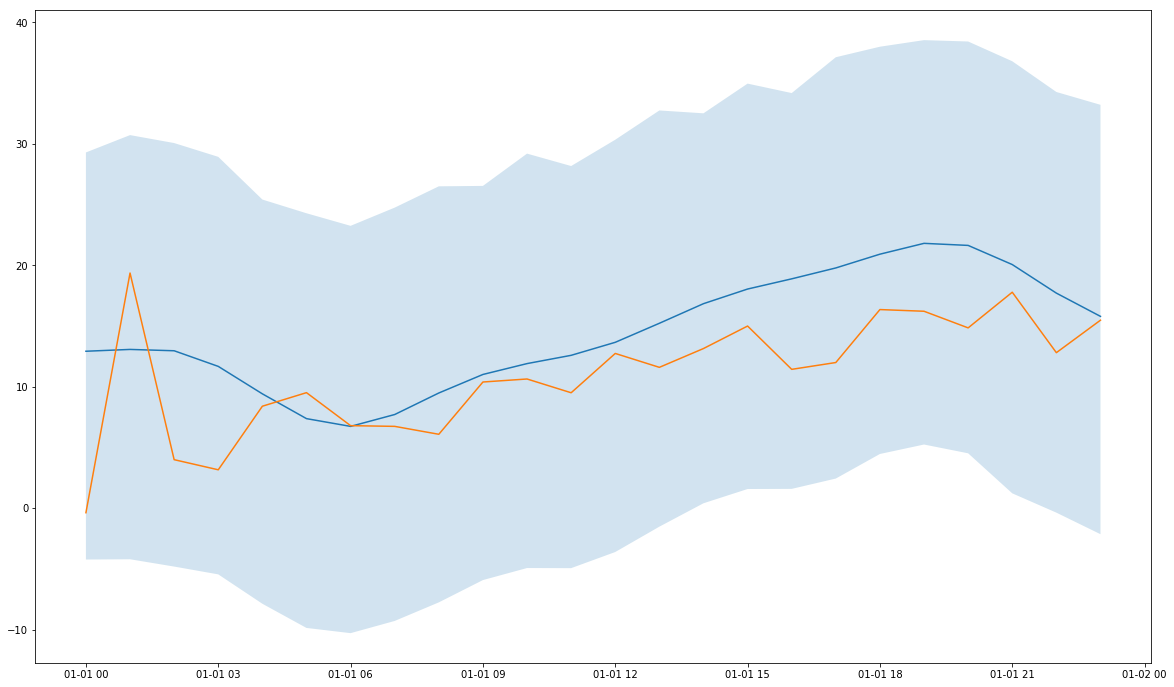

In [13]:
plt.figure(figsize=(20,12))

plt.plot(
    forecast_data.tail(depth)["ds"], 
    forecast_data.tail(depth)["yhat"]
)

plt.plot(
    df_test.head(depth)["ds"], 
    df_test.head(depth)["y"]
)

plt.fill_between(
    forecast_data.tail(depth)["ds"].dt.to_pydatetime(),
    forecast_data.tail(depth)["yhat_lower"],
    forecast_data.tail(depth)["yhat_upper"],
    alpha=0.2
)

plt.show()

### 1 Week

In [14]:
future_data = model.make_future_dataframe(periods=7*depth, freq = 'h')
forecast_data = model.predict(future_data)

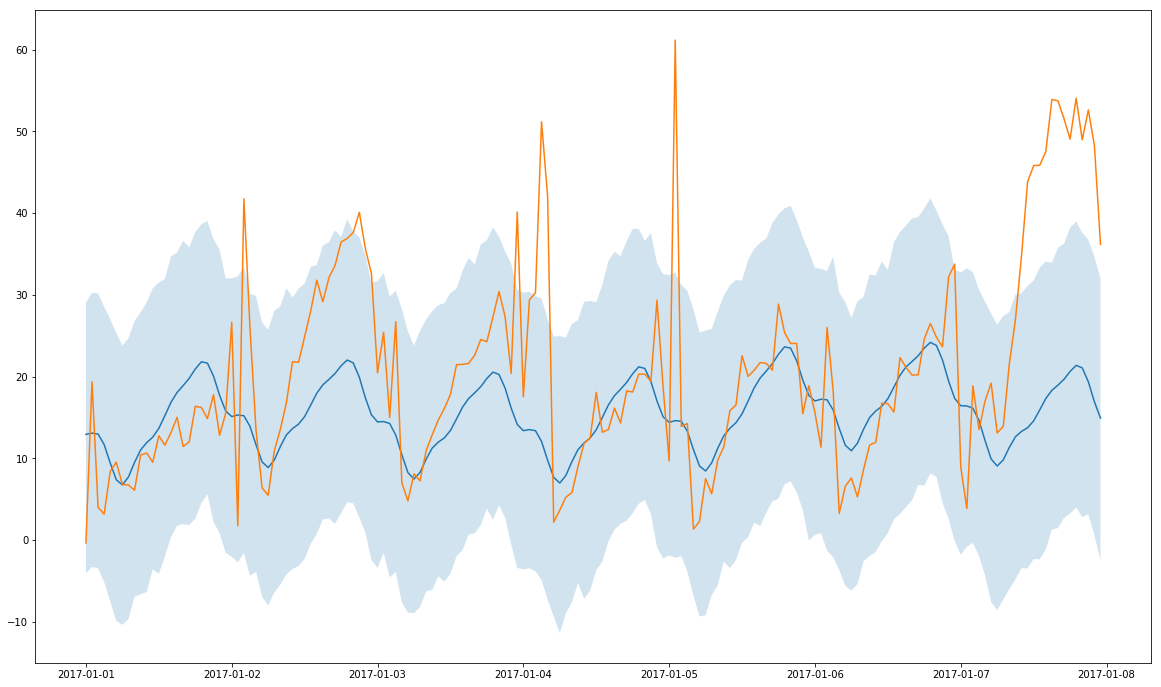

In [15]:
plt.figure(figsize=(20,12))

plt.plot(
    forecast_data.tail(7*depth)["ds"], 
    forecast_data.tail(7*depth)["yhat"]
)

plt.plot(
    df_test.head(7*depth)["ds"], 
    df_test.head(7*depth)["y"]
)

plt.fill_between(
    forecast_data.tail(7*depth)["ds"].dt.to_pydatetime(),
    forecast_data.tail(7*depth)["yhat_lower"],
    forecast_data.tail(7*depth)["yhat_upper"],
    alpha=0.2
)

plt.show()

### 1 Month

In [16]:
future_data = model.make_future_dataframe(periods=31*depth, freq = 'h')
forecast_data = model.predict(future_data)

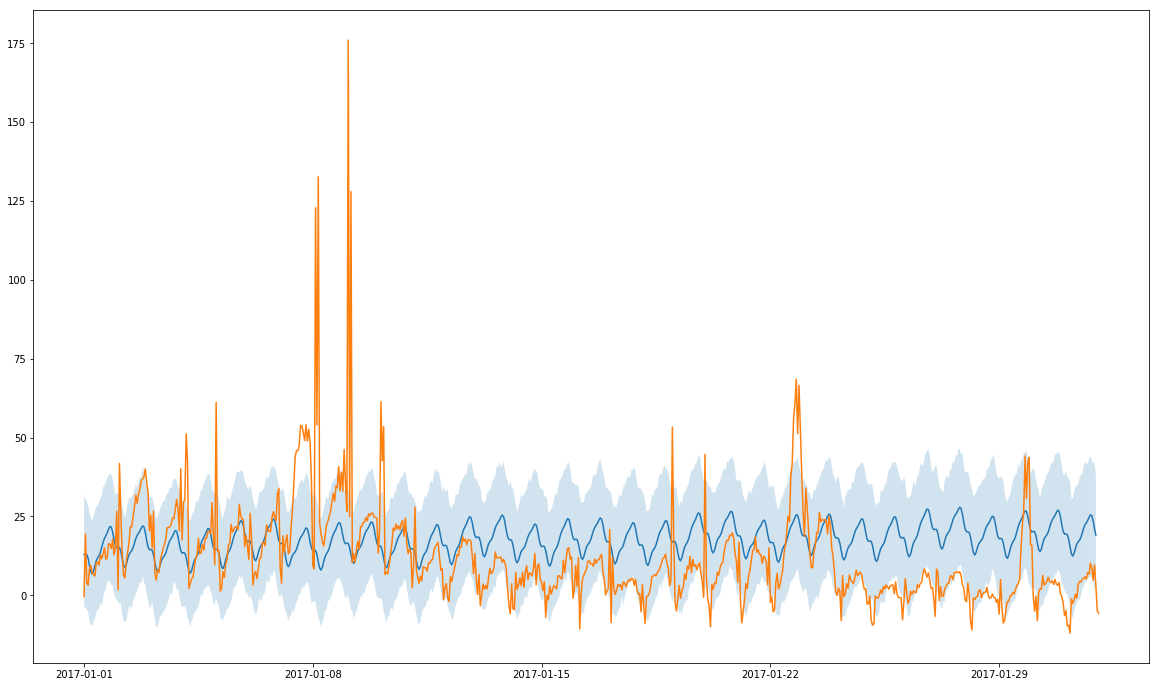

In [17]:
plt.figure(figsize=(20,12))

plt.plot(
    forecast_data.tail(31*depth)["ds"], 
    forecast_data.tail(31*depth)["yhat"]
)

plt.plot(
    df_test.head(31*depth)["ds"], 
    df_test.head(31*depth)["y"]
)

plt.fill_between(
    forecast_data.tail(31*depth)["ds"].dt.to_pydatetime(),
    forecast_data.tail(31*depth)["yhat_lower"],
    forecast_data.tail(31*depth)["yhat_upper"],
    alpha=0.2
)

plt.show()

In [15]:
future_data = model.make_future_dataframe(periods=6*31*depth, freq = 'h')
forecast_data = model.predict(future_data)

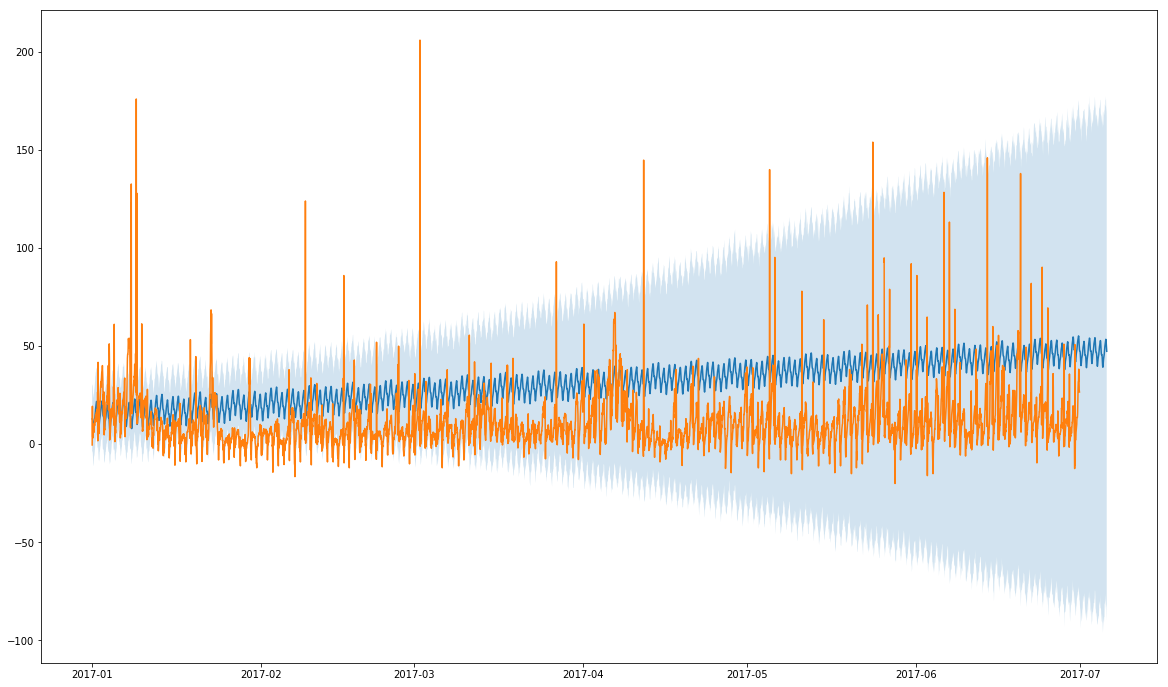

In [16]:
plt.figure(figsize=(20,12))

plt.plot(
    forecast_data.tail(6*31*depth)["ds"], 
    forecast_data.tail(6*31*depth)["yhat"]
)

plt.plot(
    df_test.head(6*31*depth)["ds"], 
    df_test.head(6*31*depth)["y"]
)

plt.fill_between(
    forecast_data.tail(6*31*depth)["ds"].dt.to_pydatetime(),
    forecast_data.tail(6*31*depth)["yhat_lower"],
    forecast_data.tail(6*31*depth)["yhat_upper"],
    alpha=0.2
)

plt.show()

We can see that on a day or week, the prediction is quite good. But on a month, there is a more important deviation. This can be explained by the fact that we have only 1 time January as reference. If we extract more years, we may find a better pattern.



# Conclusion

The idea of this notebook was not to evaluate exactly a prediction with FBProphet but discover it and see how it can be usefull.
We can regret the fact that we cannot provide additionnals informations (for example weather in the case of delays prediction) which can be usefull. 
Nevertheless, this model is great to discover pattern in timeseries (for example vacation, important days or hours)